In [3]:
import joblib
import pandas as pd
import numpy as np

# Load pipeline
pipeline = joblib.load("../models/churn_pipeline.pkl")

# Get preprocessor and model
preprocessor = pipeline.named_steps["preprocessor"]
model = pipeline.named_steps["model"]

# ---------------- FEATURE NAMES ----------------

# Numeric features
num_features = preprocessor.transformers_[0][2]

# Categorical features (one-hot encoded)
cat_encoder = preprocessor.transformers_[1][1]
cat_features = cat_encoder.get_feature_names_out(
    preprocessor.transformers_[1][2]
)

# Combine feature names
feature_names = np.concatenate([num_features, cat_features])

# ---------------- COEFFICIENTS ----------------
coefficients = model.coef_[0]

# Create DataFrame
feature_importance = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Abs_Coefficient": np.abs(coefficients)
})

# Sort by importance
feature_importance = feature_importance.sort_values(
    by="Abs_Coefficient",
    ascending=False
)

print(feature_importance.head(15))

                                 Feature  Coefficient  Abs_Coefficient
0                                 tenure    -1.186645         1.186645
1                         MonthlyCharges    -0.819879         0.819879
39                     Contract_Two year    -0.776437         0.776437
17           InternetService_Fiber optic     0.774352         0.774352
16                   InternetService_DSL    -0.685882         0.685882
37               Contract_Month-to-month     0.636133         0.636133
2                           TotalCharges     0.503397         0.503397
20    OnlineSecurity_No internet service    -0.311962         0.311962
29       TechSupport_No internet service    -0.311962         0.311962
26  DeviceProtection_No internet service    -0.311962         0.311962
18                    InternetService_No    -0.311962         0.311962
23      OnlineBackup_No internet service    -0.311962         0.311962
35   StreamingMovies_No internet service    -0.311962         0.311962
32    

c:\Users\AR\telco-customer-churn\venv\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\AR\telco-customer-churn\venv\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.4.1.post1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\AR\telco-customer-churn\venv\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.4.1.

c:\Users\AR\telco-customer-churn\venv\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\AR\telco-customer-churn\venv\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.4.1.post1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\AR\telco-customer-churn\venv\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.4.1.

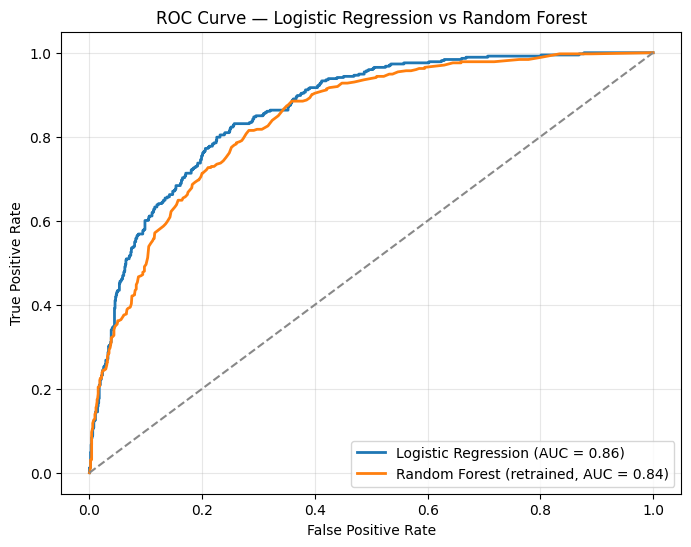

Logistic Regression AUC: 0.863
Random Forest (retrained) AUC: 0.840


In [8]:
# --- LR vs RF ROC Comparison (LR uses saved pipeline; RF retrained to avoid pickle/version issues)
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load data and clean
df = pd.read_csv("../data/raw/telco_churn.csv")
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# Prepare features & target
X = df.drop(columns=["customerID", "Churn"]) 
y = df["Churn"].map({"Yes": 1, "No": 0})

# Train/test split (same seed as training)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load full saved pipeline (preprocessor + LR model)
pipeline_full = joblib.load("../models/churn_pipeline.pkl")
preprocessor = pipeline_full.named_steps["preprocessor"]

# LR probabilities using the saved full pipeline
lr_probs = pipeline_full.predict_proba(X_test)[:, 1]

# Transform training/test sets using the saved preprocessor
X_train_trans = preprocessor.transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# Retrain a RandomForest with current sklearn to avoid pickle/version issues
rf_current = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_current.fit(X_train_trans, y_train)

# Get RF probabilities
rf_probs = rf_current.predict_proba(X_test_trans)[:, 1]

# Compute ROC curves and AUC
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
auc_lr = auc(fpr_lr, tpr_lr)
auc_rf = auc(fpr_rf, tpr_rf)

# Plot comparison
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})", lw=2)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (retrained, AUC = {auc_rf:.2f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="#888888")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression vs Random Forest")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Print AUCs
print(f"Logistic Regression AUC: {auc_lr:.3f}")
print(f"Random Forest (retrained) AUC: {auc_rf:.3f}")

In [11]:
# --- Performance Metrics: LR vs RF
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Get predictions for both models
lr_preds = (lr_probs >= 0.4).astype(int)
rf_preds = (rf_probs >= 0.4).astype(int)

# Calculate metrics
metrics = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"],
    "Logistic Regression": [
        accuracy_score(y_test, lr_preds),
        precision_score(y_test, lr_preds),
        recall_score(y_test, lr_preds),
        f1_score(y_test, lr_preds),
        auc_lr
    ],
    "Random Forest": [
        accuracy_score(y_test, rf_preds),
        precision_score(y_test, rf_preds),
        recall_score(y_test, rf_preds),
        f1_score(y_test, rf_preds),
        auc_rf
    ]
}

metrics_df = pd.DataFrame(metrics)
print("\n" + "="*60)
print("MODEL COMPARISON MATRIX")
print("="*60)
print(metrics_df.to_string(index=False))
print("="*60)

# Detailed classification reports
print("\n" + "="*60)
print("LOGISTIC REGRESSION - DETAILED REPORT")
print("="*60)
print(classification_report(y_test, lr_preds, target_names=["No Churn", "Churn"]))

print("\n" + "="*60)
print("RANDOM FOREST - DETAILED REPORT")
print("="*60)
print(classification_report(y_test, rf_preds, target_names=["No Churn", "Churn"]))

# Confusion matrices
print("\n" + "="*60)
print("CONFUSION MATRICES")
print("="*60)
print("\nLogistic Regression:")
print(confusion_matrix(y_test, lr_preds))
print("\nRandom Forest:")
print(confusion_matrix(y_test, rf_preds))



MODEL COMPARISON MATRIX
   Metric  Logistic Regression  Random Forest
 Accuracy             0.744500       0.791341
Precision             0.510673       0.597531
   Recall             0.833780       0.648794
 F1-Score             0.633401       0.622108
      AUC             0.862933       0.840366

LOGISTIC REGRESSION - DETAILED REPORT
              precision    recall  f1-score   support

    No Churn       0.92      0.71      0.80      1036
       Churn       0.51      0.83      0.63       373

    accuracy                           0.74      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.74      0.76      1409


RANDOM FOREST - DETAILED REPORT
              precision    recall  f1-score   support

    No Churn       0.87      0.84      0.86      1036
       Churn       0.60      0.65      0.62       373

    accuracy                           0.79      1409
   macro avg       0.73      0.75      0.74      1409
weighted avg       0.80     

Positive coefficient → increases churn probability

Negative coefficient → decreases churn probability


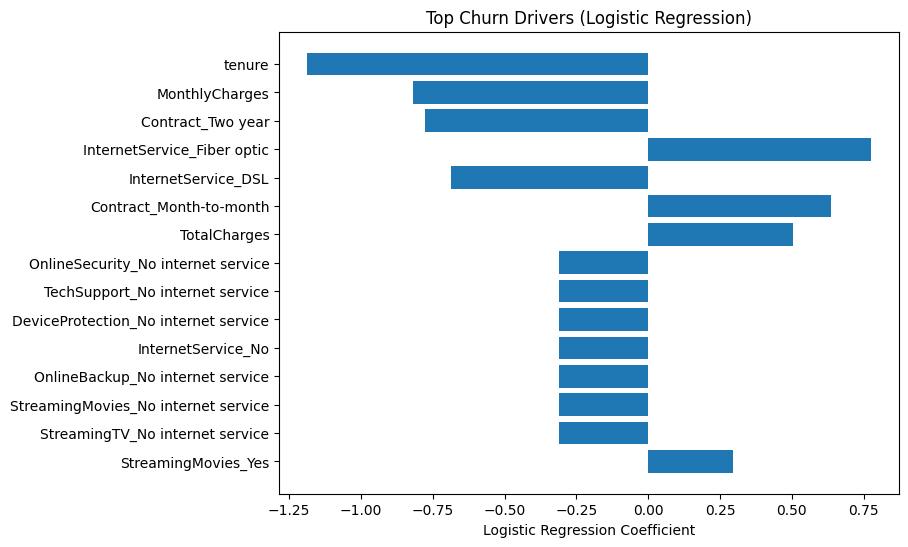

In [4]:
import matplotlib.pyplot as plt

top_n = 15
top_features = feature_importance.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(
    top_features["Feature"][::-1],
    top_features["Coefficient"][::-1]
)
plt.xlabel("Logistic Regression Coefficient")
plt.title("Top Churn Drivers (Logistic Regression)")
plt.show()
